In [11]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import pandas as pd
import Scripts.airfoil as af
import Scripts.fishUtilities as fu
import Scripts.fishFits as ff
import Scripts.surfaceAreaEstimators as sea
import Scripts.volumeEstimators as ve
import Scripts.cotEstimators as cot
import scipy.stats as st

from pathlib import Path
from scipy import stats
from scipy.optimize import curve_fit

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [12]:
# returns confidence interval of mean
def confIntMean(a, conf=0.95):
  mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
  return mean - m*sem, mean + m*sem

# returns power law
def power_law(xData, a, b):
        return a * xData ** b

# method to fit data
def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[1, 1])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [13]:
imagePath = r'/media/mco143/2TB/Surface Area Photos/BCF/SubCarangiform'
figurePath = r'/home/mco143/Documents/gitRepos/fish_contours/Figures'

In [14]:
# Split work depending on input images
def process_top(imageList):
    # make a copy of the image
    topImage = imageList[0].copy()
    if(len(imageList) < 2):
        topImageFull = imageList[0].copy()
    else:
        topImageFull = imageList[1].copy()
    # get contours
    cntsTop, hullTop = fu.get_contours(topImage)
    cntsTopFull, hullTopFull = fu.get_contours(topImageFull)
    
    # Find the area ratio of fins and no fins
    areaTopFull = cv2.contourArea(cntsTopFull)
    areaTopNF = cv2.contourArea(cntsTop)
    areaRatioTop = (1-np.abs(areaTopNF/areaTopFull))

    # split the hull into top and bottom
    (cxTop, cyTop), topHullTop, bottomHullTop = fu.split_by_centroid_top(topImage.shape, cntsTop)
    (cxTopFull, cyTopFull), topHullTopFull, bottomHullTopFull = fu.split_by_centroid_top(topImageFull.shape, cntsTopFull)

    # scale contour data
    areaTop, tHullTop, bHullTop = fu.scale_data_top(topHullTop, bottomHullTop)
    areaTopFull, tHullTopFull, bHullTopFull = fu.scale_data_top(topHullTopFull, bottomHullTopFull)
    
    # get min and max points
    maxPointsTop, minPointsTop = fu.get_min_max(tHullTop, bHullTop)
    
    # fit data
    topPolyArea, topFitTop, bottomFitTop = ff.fit_top_contours_poly(tHullTop, bHullTop, 6)
    nacaArea, m, thickness, d0, xu, yu, xl, yl = ff.fit_top_contours(areaTop, np.mean([minPointsTop[0],maxPointsTop[0]]), np.abs(minPointsTop[1])+maxPointsTop[1], (tHullTop[1,-5]+np.abs(bHullTop[1,-5]))/2.0)
    
    return (areaRatioTop, [cntsTop, cntsTopFull], [maxPointsTop, minPointsTop],
            [topFitTop, bottomFitTop], [m, thickness, d0], [tHullTop, bHullTop])

In [15]:
def process_side(imageList):
    # make a copy of the image
    sideImage = imageList[0].copy()
    sideImageFull = imageList[1].copy()

    # get contours
    cntsSide, hullSide = fu.get_contours(sideImage)
    cntsSideFull, hullSideFull = fu.get_contours(sideImageFull)
    
    # Find the area ratio of fins and no fins
    areaSideFull = cv2.contourArea(cntsSideFull)
    areaSideNF = cv2.contourArea(cntsSide)
    areaRatioSide = (1-np.abs(areaSideNF/areaSideFull))
    
    (cxSide, cySide), areaSideNF, topHullSide, bottomHullSide = fu.split_by_centroid_side(sideImage.shape, cntsSide)
    (cxSideFull, cySideFull), areaSideFull, topHullSideFull, bottomHullSideFull = fu.split_by_centroid_side(sideImageFull.shape, cntsSideFull)

    # scale contour data
    scaleFactorSide, tHullSide, bHullSide = fu.scale_data(topHullSide, bottomHullSide)
    scaleFactorSideFull, tHullSideFull, bHullSideFull = fu.scale_data(topHullSideFull, bottomHullSideFull)
    
    # get min and max points
    maxPointsSide, minPointsSide = fu.get_min_max(tHullSide, bHullSide)
    
    #fit data
    topFitSide, bottomFitSide = ff.fit_side_contours(tHullSide, bHullSide, 6)
    
    return (areaRatioSide, [cntsSide, cntsSideFull], [maxPointsSide, minPointsSide], [topFitSide, bottomFitSide], [tHullSide, bHullSide])

In [16]:
imagePathSide = fu.get_image_files(imagePath, 'scannedSalmonSideNF.png')
imagePathSideFull = fu.get_image_files(imagePath, 'scannedSalmonSide.png')

# import images
imageSide = cv2.imread(imagePathSide[0].as_posix())
imageSideFull = cv2.imread(imagePathSideFull[0].as_posix())


imagePathTop = fu.get_image_files(imagePath, 'scannedSalmonTopNF.png')
imagePathTopFull = fu.get_image_files(imagePath, 'scannedSalmonTop.png')

if(len(imagePathTopFull) == 0):
    imagePathTopFull = imagePathTop


# import images
imageTop = cv2.imread(imagePathTop[0].as_posix())
imageTopFull = cv2.imread(imagePathTopFull[0].as_posix())

# Salmon Data
sideArea_salmon, sideContours_salmon, sidePoints_salmon, sideFits_salmon, sideHull_salmon = process_side([imageSide, imageSideFull])

topArea_salmon, topContours_salmon, topPoints_salmon, topPolyFits_salmon, nacaFits_salmon, topHull_salmon = process_top([imageTop, imageTopFull])

In [17]:
imagePathSide = fu.get_image_files(imagePath, 'atlanticCodSideNF.png')
imagePathSideFull = fu.get_image_files(imagePath, 'atlanticCodSide.png')

# import images
imageSide = cv2.imread(imagePathSide[0].as_posix())
imageSideFull = cv2.imread(imagePathSideFull[0].as_posix())


imagePathTop = fu.get_image_files(imagePath, 'atlanticCodTopNF.png')
imagePathTopFull = fu.get_image_files(imagePath, 'atlanticCodTop.png')

if(len(imagePathTopFull) == 0):
    imagePathTopFull = imagePathTop


# import images
imageTop = cv2.imread(imagePathTop[0].as_posix())
imageTopFull = cv2.imread(imagePathTopFull[0].as_posix())

# Atlantic Cod Data
sideArea_cod, sideContours_cod, sidePoints_cod, sideFits_cod, sideHull_cod = process_side([imageSide, imageSideFull])

topArea_cod, topContours_cod, topPoints_cod, topPolyFits_cod, nacaFits_cod, topHull_cod = process_top([imageTop, imageTopFull])

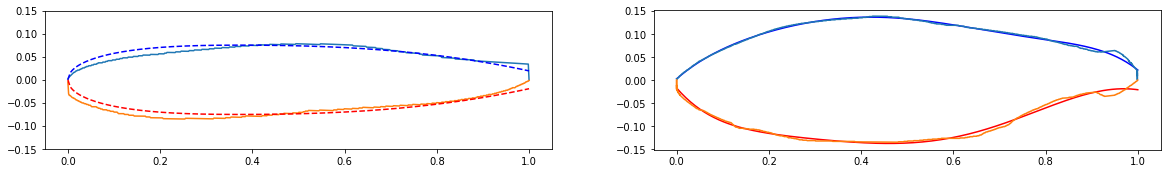

In [18]:
dx = np.linspace(0, 1.0, 200)
#nacaFits = [0.3973, 0.16, 0.01]
m = nacaFits_salmon[0]
thickness = nacaFits_salmon[1]
d0 = nacaFits_salmon[2]

topPolySide = np.poly1d(sideFits_salmon[0])
bottomPolySide = np.poly1d(sideFits_salmon[1])
topPolyTop = np.poly1d(topPolyFits_salmon[0])
bottomPolyTop = np.poly1d(topPolyFits_salmon[1])

X, Y = af.naca4_modified(dx, m, thickness, 1.0, d0)
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(topHull_salmon[0][0], topHull_salmon[0][1])
ax1.plot(topHull_salmon[1][0], topHull_salmon[1][1])
ax1.plot(X[0], Y[0], 'b--')
ax1.plot(X[1], Y[1], 'r--')
ax1.set_ylim([-0.15, 0.15])
ax1.set_aspect('equal')
ax2.plot(dx, topPolySide(dx), 'b')
ax2.plot(dx, bottomPolySide(dx), 'r')
ax2.plot(sideHull_salmon[0][0], sideHull_salmon[0][1])
ax2.plot(sideHull_salmon[1][0], sideHull_salmon[1][1])
ax2.set_aspect('equal')

In [19]:
scalingData = r'/media/mco143/2TB/Dropbox/UUV Project/Databases/osheaData.xlsx'

salmonDF = pd.read_excel(scalingData, sheet_name='Salmon')
salmon_length = salmonDF['Length [cm]'].values
salmon_area = salmonDF['SA [cm^2]'].values
salmon_mass = salmonDF['Mass [g]']

salmonDF = pd.read_excel(scalingData, sheet_name='Cod')
cod_length = salmonDF['Length [cm]'].values
cod_area = salmonDF['SA [cm^2]'].values
cod_mass = salmonDF['Mass [g]']

# convert from cm to meters
# area in m^2
# mass in kg
salmon_length = salmon_length / 100
salmon_area = salmon_area / 100**2
salmon_mass = salmon_mass / 1000

cod_length = cod_length / 100
cod_area = cod_area / 100**2
cod_mass = cod_mass / 1000

density = 1025

# Scanned Salmon Data
scanned_length = 0.397
scanned_area = 696.8288 / 100**2
scanned_volume = 823.6813 / 100**3

# Add to the salmon data
#salmon_length = np.append(salmon_length, scanned_length)
#salmon_area = np.append(salmon_area, scanned_area*0.9)

Data for the salmon species

In [20]:
ika_salmon = np.zeros(len(salmon_length))
es_salmon = np.zeros(len(salmon_length))
pd_salmon = np.zeros(len(salmon_length))
ea_salmon = np.zeros(len(salmon_length))

for idx, length in enumerate(salmon_length):
    ika_salmon[idx], _ = sea.determine_surface_area(1, 2, 0, length*0.95, sideFits_salmon[0], sideFits_salmon[1], nacaFits_salmon, nacaFits_salmon)

    _, es_salmon[idx], _ = sea.equivalentSpheroid(length, salmon_mass[idx], density)
    
    ea_salmon[idx] = sea.ellipsoidApproximation(length*0.95, (np.abs(topPoints_salmon[0][1]) + np.abs(topPoints_salmon[1][1]))*length, (np.abs(sidePoints_salmon[0][1]) + np.abs(sidePoints_salmon[1][1]))*length)
    
    pd_salmon[idx] = sea.partitionDisc(length*0.95, sideFits_salmon[0], sideFits_salmon[1], topPolyFits_salmon[0], topPolyFits_salmon[1])

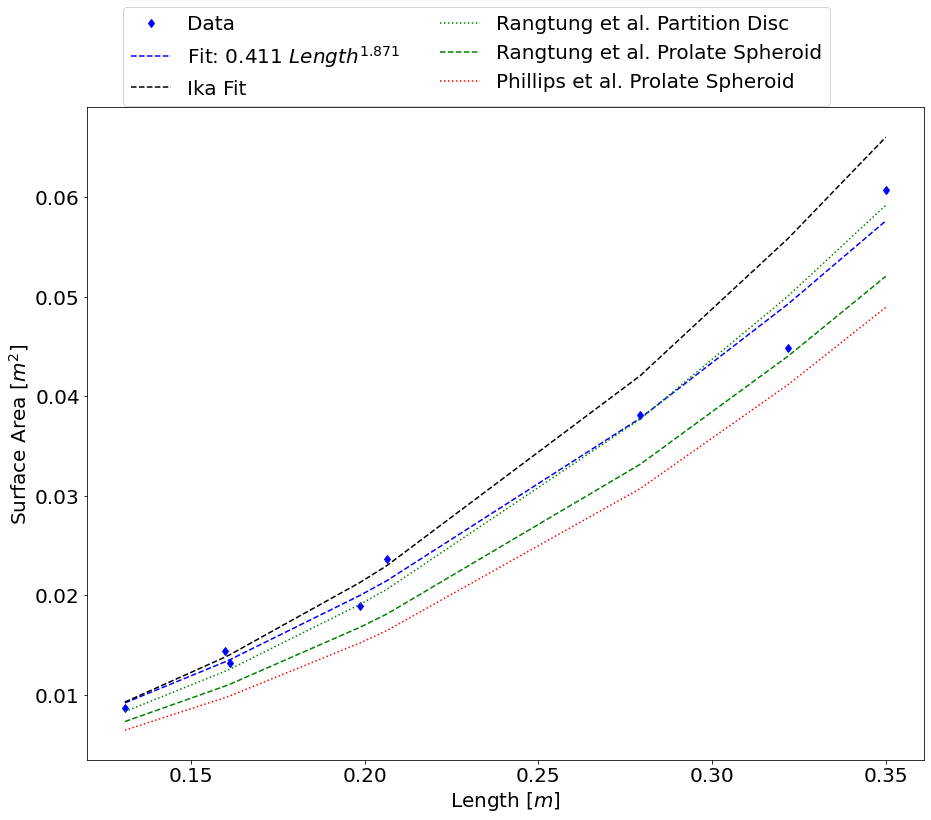

In [30]:
plt.rcParams.update({'font.size': 20})

ika_salmon = ika_salmon + (ika_salmon * sideArea_salmon)

popt_salmon, r_sq_salmon = fit_data(salmon_length, salmon_area)
popt_ika, r_sq_ika = fit_data(salmon_length, ika_salmon)
popt_esMethod, r_sq_esMethod = fit_data(salmon_length, es_salmon)
popt_eaMethod, r_sq_eaMethod = fit_data(salmon_length, ea_salmon)
popt_pdMethod, r_sq_pdMethod = fit_data(salmon_length, pd_salmon)

fig1, ax1 = plt.subplots(figsize=((15, 12)))
ax1.plot(salmon_length, salmon_area, 'bd', label='Data')
ax1.plot(salmon_length, power_law(salmon_length, *popt_salmon), 'b--', label="Fit: " + str(np.round(popt_salmon[0], 3)) + " $Length^{" + str(np.round(popt_salmon[1], 3)) + '}$')
ax1.plot(salmon_length, power_law(salmon_length, *popt_ika), 'k--', label="Ika Fit")
ax1.plot(salmon_length, power_law(salmon_length, *popt_pdMethod), 'g:', label='Rangtung et al. Partition Disc')
ax1.plot(salmon_length, power_law(salmon_length, *popt_eaMethod), 'g--', label="Rangtung et al. Prolate Spheroid")
ax1.plot(salmon_length, power_law(salmon_length, *popt_esMethod), 'r:', label="Phillips et al. Prolate Spheroid")
ax1.set_ylabel('Surface Area $[m^2]$')
ax1.set_xlabel('Length $[m]$')
ax1.legend(loc='best', ncol = 2, bbox_to_anchor=(0.9, 1.17))
fig1.savefig(Path(figurePath).joinpath('salmon_noArea.png'), facecolor='w', bbox_inches='tight')

In [22]:
error_ika = [np.sqrt(np.sum(np.abs(ika_salmon - salmon_area)**2)/len(salmon_area)), np.sum(np.abs(ika_salmon - salmon_area))/len(salmon_area)]
error_pd = [np.sqrt(np.sum(np.abs(pd_salmon - salmon_area)**2)/len(salmon_area)), np.sum(np.abs(pd_salmon - salmon_area))/len(salmon_area)]
error_ea = [np.sqrt(np.sum(np.abs(ea_salmon- salmon_area)**2)/len(salmon_area)), np.sum(np.abs(ea_salmon - salmon_area))/len(salmon_area)]
error_es = [np.sqrt(np.sum(np.abs(es_salmon - salmon_area)**2)/len(salmon_area)), np.sum(np.abs(es_salmon - salmon_area))/len(salmon_area)]

print(error_ika, error_pd, error_ea, error_es)

[0.0024680486769558968, 0.0015631515326878674] [0.003499831179376699, 0.002931643634768894] [0.006647767261929231, 0.005743337973022105] [0.008168161296060463, 0.007419707341551453]


Data for the Cod Species

In [23]:
ika_cod = np.zeros(len(cod_length))
es_cod = np.zeros(len(cod_length))
pd_cod = np.zeros(len(cod_length))
ea_cod = np.zeros(len(cod_length))

for idx, length in enumerate(cod_length):
    ika_cod[idx], _ = sea.determine_surface_area(1, 2, 0, length, sideFits_cod[0], sideFits_cod[1], nacaFits_cod, nacaFits_cod)

    _, es_cod[idx], _ = sea.equivalentSpheroid(length, cod_mass[idx], density)
    
    ea_cod[idx] = sea.ellipsoidApproximation(length, (np.abs(topPoints_cod[0][1]) + np.abs(topPoints_cod[1][1]))*length, (np.abs(sidePoints_cod[0][1]) + np.abs(sidePoints_cod[1][1]))*length)
    
    pd_cod[idx] = sea.partitionDisc(length, sideFits_cod[0], sideFits_cod[1], topPolyFits_cod[0], topPolyFits_cod[1])

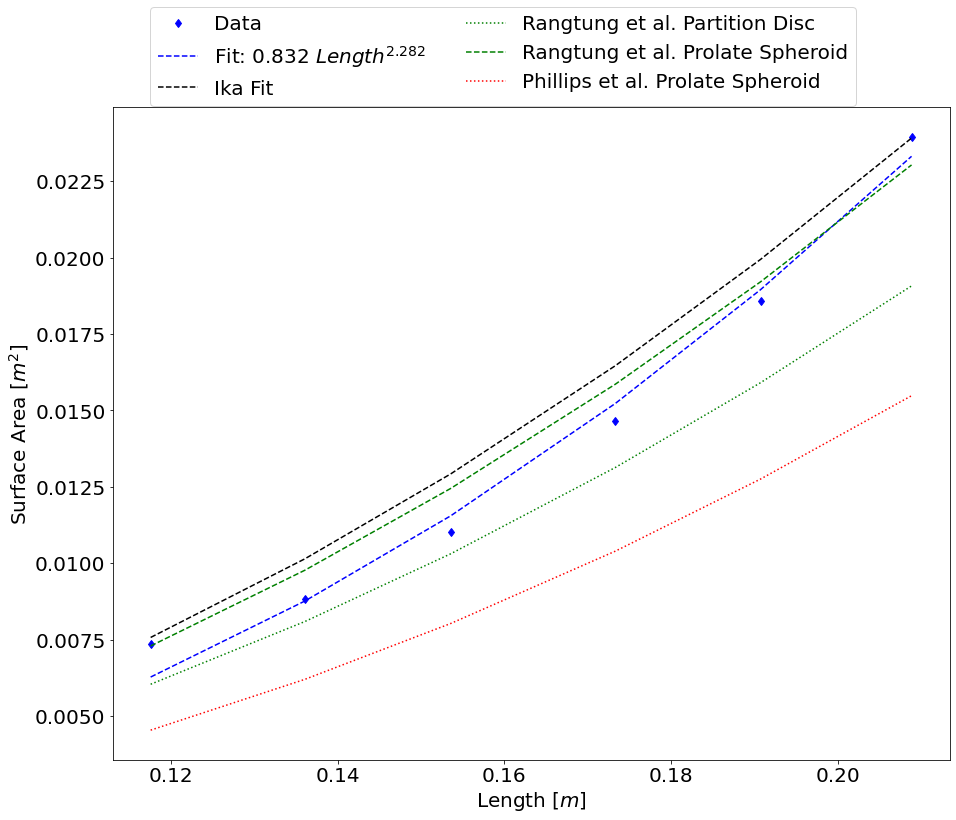

In [24]:
ika_cod = ika_cod + (ika_cod * sideArea_cod)

popt_cod, r_sq_cod = fit_data(cod_length, cod_area)
popt_ika, r_sq_ika = fit_data(cod_length, ika_cod)
popt_esMethod, r_sq_esMethod = fit_data(cod_length, es_cod)
popt_eaMethod, r_sq_eaMethod = fit_data(cod_length, ea_cod)
popt_pdMethod, r_sq_pdMethod = fit_data(cod_length, pd_cod)

fig2, ax2 = plt.subplots(figsize=((15, 12)))
ax2.plot(cod_length, cod_area, 'bd', label='Data')
ax2.plot(cod_length, power_law(cod_length, *popt_cod), 'b--', label="Fit: " + str(np.round(popt_cod[0], 3)) + " $Length^{" + str(np.round(popt_cod[1], 3)) + '}$')
ax2.plot(cod_length, power_law(cod_length, *popt_ika), 'k--', label="Ika Fit")
ax2.plot(cod_length, power_law(cod_length, *popt_pdMethod), 'g:', label='Rangtung et al. Partition Disc')
ax2.plot(cod_length, power_law(cod_length, *popt_eaMethod), 'g--', label="Rangtung et al. Prolate Spheroid")
ax2.plot(cod_length, power_law(cod_length, *popt_esMethod), 'r:', label="Phillips et al. Prolate Spheroid")
ax2.set_ylabel('Surface Area $[m^2]$')
ax2.set_xlabel('Length $[m]$')
ax2.legend(loc='best', ncol = 2, bbox_to_anchor=(0.9, 1.17))
fig2.savefig(Path(figurePath).joinpath('cod_noArea.png'), facecolor='w', bbox_inches='tight')

In [25]:
error_ika = [np.sqrt(np.sum(np.abs(ika_cod - cod_area)**2)/len(cod_area)), np.sum(np.abs(ika_cod - cod_area))/len(cod_area)]
error_pd = [np.sqrt(np.sum(np.abs(pd_cod - cod_area)**2)/len(cod_area)), np.sum(np.abs(pd_cod - cod_area))/len(cod_area)]
error_ea = [np.sqrt(np.sum(np.abs(ea_cod- cod_area)**2)/len(cod_area)), np.sum(np.abs(ea_cod - cod_area))/len(cod_area)]
error_es = [np.sqrt(np.sum(np.abs(es_cod - cod_area)**2)/len(cod_area)), np.sum(np.abs(es_cod - cod_area))/len(cod_area)]

print(error_ika, error_pd, error_ea, error_es)

[0.0013240362384535586, 0.0011063864089372497] [0.002446313361024643, 0.0019711295161514166] [0.0009648705222498853, 0.0008601191693413889] [0.004965128848599514, 0.004493865149820417]


Adding Fin Surface Area to all the algorithms

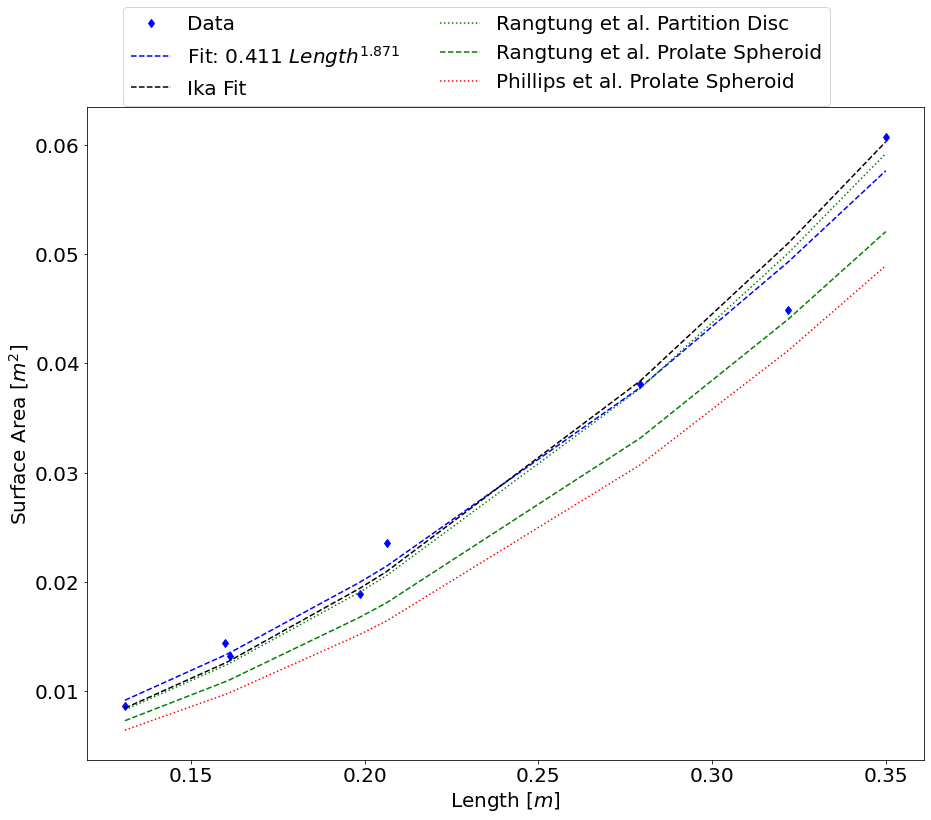

In [26]:
es_salmon = es_salmon + (es_salmon * sideArea_salmon)
ea_salmon = ea_salmon + (ea_salmon * sideArea_salmon)
pd_salmon = pd_salmon + (pd_salmon * sideArea_salmon)

popt_salmon, r_sq_salmon = fit_data(salmon_length, salmon_area)
popt_ika, r_sq_ika = fit_data(salmon_length, ika_salmon)
popt_esMethod, r_sq_esMethod = fit_data(salmon_length, es_salmon)
popt_eaMethod, r_sq_eaMethod = fit_data(salmon_length, ea_salmon)
popt_pdMethod, r_sq_pdMethod = fit_data(salmon_length, pd_salmon)

fig3, ax3 = plt.subplots(figsize=((15, 12)))
ax3.plot(salmon_length, salmon_area, 'bd', label='Data')
ax3.plot(salmon_length, power_law(salmon_length, *popt_salmon), 'b--', label="Fit: " + str(np.round(popt_salmon[0], 3)) + " $Length^{" + str(np.round(popt_salmon[1], 3)) + '}$')
ax3.plot(salmon_length, power_law(salmon_length, *popt_ika), 'k--', label="Ika Fit")
ax3.plot(salmon_length, power_law(salmon_length, *popt_pdMethod), 'g:', label='Rangtung et al. Partition Disc')
ax3.plot(salmon_length, power_law(salmon_length, *popt_eaMethod), 'g--', label="Rangtung et al. Prolate Spheroid")
ax3.plot(salmon_length, power_law(salmon_length, *popt_esMethod), 'r:', label="Phillips et al. Prolate Spheroid")
ax3.set_ylabel('Surface Area $[m^2]$')
ax3.set_xlabel('Length $[m]$')
ax3.legend(loc='best', ncol = 2, bbox_to_anchor=(0.9, 1.17))
fig3.savefig(Path(figurePath).joinpath('salmon_withArea.png'), facecolor='w', bbox_inches='tight')

In [27]:
error_ika = [np.sqrt(np.sum(np.abs(ika_salmon - salmon_area)**2)/len(salmon_area)), np.sum(np.abs(ika_salmon - salmon_area))/len(salmon_area)]
error_pd = [np.sqrt(np.sum(np.abs(pd_salmon - salmon_area)**2)/len(salmon_area)), np.sum(np.abs(pd_salmon - salmon_area))/len(salmon_area)]
error_ea = [np.sqrt(np.sum(np.abs(ea_salmon- salmon_area)**2)/len(salmon_area)), np.sum(np.abs(ea_salmon - salmon_area))/len(salmon_area)]
error_es = [np.sqrt(np.sum(np.abs(es_salmon - salmon_area)**2)/len(salmon_area)), np.sum(np.abs(es_salmon - salmon_area))/len(salmon_area)]

print(error_ika, error_pd, error_ea, error_es)

[0.0024680486769558968, 0.0015631515326878674] [0.002333567869855205, 0.0016705805506452168] [0.0043774440672215455, 0.0036331356663157816] [0.005866971412555063, 0.005469930796156675]


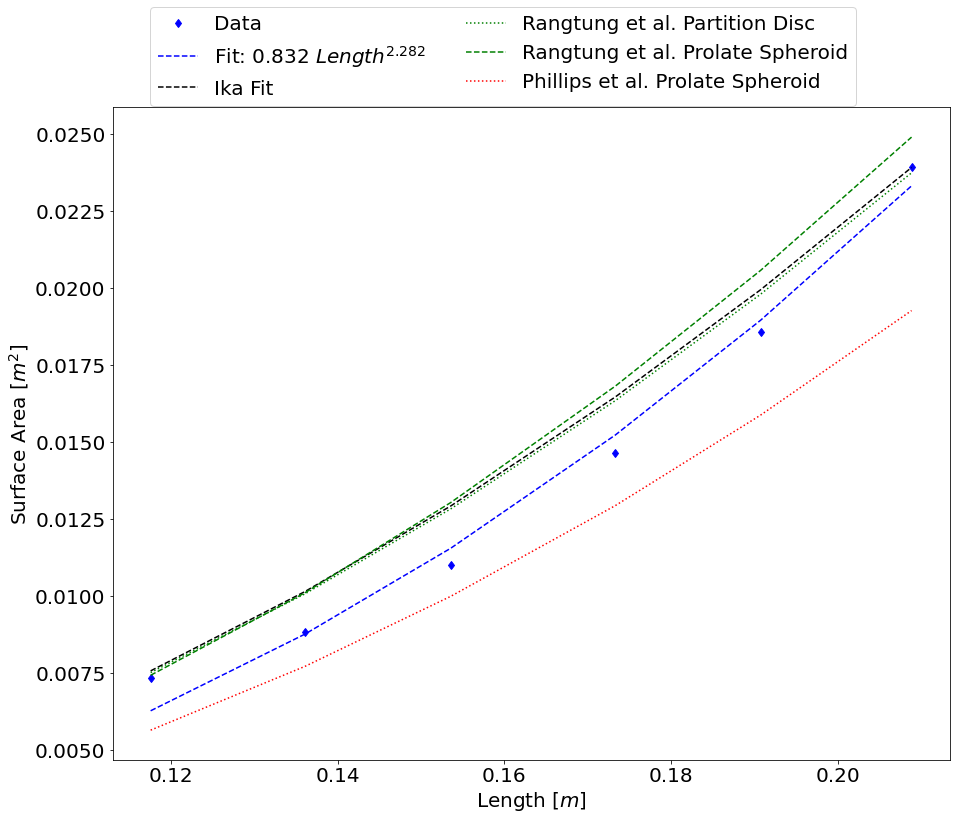

In [28]:
es_cod = es_cod + (es_cod * sideArea_cod)
ea_cod = es_cod + (ea_cod * sideArea_cod)
pd_cod = pd_cod + (pd_cod * sideArea_cod)

popt_cod, r_sq_cod = fit_data(cod_length, cod_area)
popt_ika, r_sq_ika = fit_data(cod_length, ika_cod)
popt_esMethod, r_sq_esMethod = fit_data(cod_length, es_cod)
popt_eaMethod, r_sq_eaMethod = fit_data(cod_length, ea_cod)
popt_pdMethod, r_sq_pdMethod = fit_data(cod_length, pd_cod)

fig2, ax2 = plt.subplots(figsize=((15, 12)))
ax2.plot(cod_length, cod_area, 'bd', label='Data')
ax2.plot(cod_length, power_law(cod_length, *popt_cod), 'b--', label="Fit: " + str(np.round(popt_cod[0], 3)) + " $Length^{" + str(np.round(popt_cod[1], 3)) + '}$')
ax2.plot(cod_length, power_law(cod_length, *popt_ika), 'k--', label="Ika Fit")
ax2.plot(cod_length, power_law(cod_length, *popt_pdMethod), 'g:', label='Rangtung et al. Partition Disc')
ax2.plot(cod_length, power_law(cod_length, *popt_eaMethod), 'g--', label="Rangtung et al. Prolate Spheroid")
ax2.plot(cod_length, power_law(cod_length, *popt_esMethod), 'r:', label="Phillips et al. Prolate Spheroid")
ax2.set_ylabel('Surface Area $[m^2]$')
ax2.set_xlabel('Length $[m]$')
ax2.legend(loc='best', ncol = 2, bbox_to_anchor=(0.9, 1.17))
fig2.savefig(Path(figurePath).joinpath('cod_withArea.png'), facecolor='w', bbox_inches='tight')

In [29]:
error_ika = [np.sqrt(np.sum(np.abs(ika_cod - cod_area)**2)/len(cod_area)), np.sum(np.abs(ika_cod - cod_area))/len(cod_area)]
error_pd = [np.sqrt(np.sum(np.abs(pd_cod - cod_area)**2)/len(cod_area)), np.sum(np.abs(pd_cod - cod_area))/len(cod_area)]
error_ea = [np.sqrt(np.sum(np.abs(ea_cod- cod_area)**2)/len(cod_area)), np.sum(np.abs(ea_cod - cod_area))/len(cod_area)]
error_es = [np.sqrt(np.sum(np.abs(es_cod - cod_area)**2)/len(cod_area)), np.sum(np.abs(es_cod - cod_area))/len(cod_area)]

print(error_ika, error_pd, error_ea, error_es)

[0.0013240362384535586, 0.0011063864089372497] [0.0012387875968808658, 0.001054146846913536] [0.0016327410929044392, 0.0014172411648567297] [0.002520341871856671, 0.002153623303044777]
